# What is this?
This is a report on the performance of a stacked ResNet18 in three configurations:
- Learning from scratch
- Pre-trained with everything unfrozen
- Pre-trained with the backbone frozen

The transform used is the following:
```
def transform_big_crop(resize=100):
    transform = T.Compose([
        T.Resize((resize, resize)),
        T.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        T.RandomResizedCrop(resize, scale=(0.7, 1), ratio=(1, 1)),
        T.RandomRotation(20),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform
```
The config file used is `hyperparam_search_shannon.json`.
An early stopping of 10 epochs was used.
### NOTES
- The transform was applied only on the detection and **not** on the exemplar.
- The normalization is **not** the ImageNet one, which should use mean = (0.485, 0.456, 0.406) and std = (0.229, 0.224, 0.225). That's probably not super important but it wouldn't hurt to redo the analysis at some point with the right normalization.

In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
from loreta.utils import read_tensorboard_log

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
PATH = os.path.join(os.environ['HKT'],'Logos-Recognition-Training/saved/hyperparam_search')
folders = glob(os.path.join(PATH, '*'))

infos = []
for folder in folders:
    infos.append(read_tensorboard_log(folder))

Here I'll show the best performing configuration for all three categories, after inspecting the Tensorboard logs. Don't put too much emphasis on "best performing", they all suck. It's just that there's no point in showing 5 learning rates for each configuration. In all cases there's horrible overfitting and the validation performance is very poor. So here I select the ones that have the best performance on the training set, and in all cases this happens with the largest learning rate that I tried, of 0.01.

In [3]:
# First select 

from_scratch = [info for info in infos if \
    not info['config']['model']['args']['pretrained'] and \
    not info['config']['model']['args']['frozen_backbone'] and \
    info['config']['optimizer']['args']['lr'] == 0.01][0]
pretrained_open = [info for info in infos if \
    info['config']['model']['args']['pretrained'] and \
    not info['config']['model']['args']['frozen_backbone'] and \
    info['config']['optimizer']['args']['lr'] == 0.01][0]  
pretrained_frozen = [info for info in infos if \
    info['config']['model']['args']['pretrained'] and \
    info['config']['model']['args']['frozen_backbone'] and \
    info['config']['optimizer']['args']['lr'] == 0.01][0]

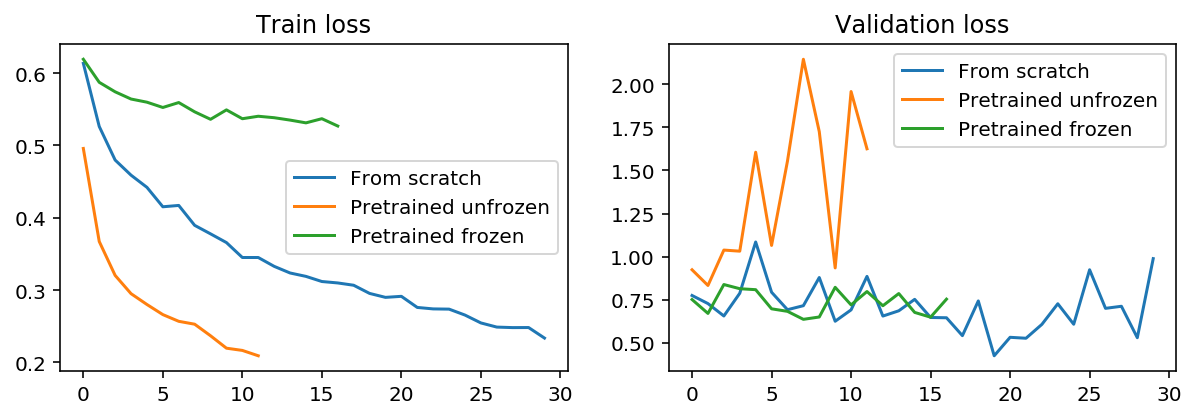

In [4]:
# Now check out the losses

fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].set_title('Train loss')
ax[0].plot(from_scratch['loss_train'], label='From scratch')
ax[0].plot(pretrained_open['loss_train'], label='Pretrained unfrozen')
ax[0].plot(pretrained_frozen['loss_train'], label='Pretrained frozen')
ax[0].legend()

ax[1].set_title('Validation loss')
ax[1].plot(from_scratch['loss_valid'], label='From scratch')
ax[1].plot(pretrained_open['loss_valid'], label='Pretrained unfrozen')
ax[1].plot(pretrained_frozen['loss_valid'], label='Pretrained frozen')
ax[1].legend()

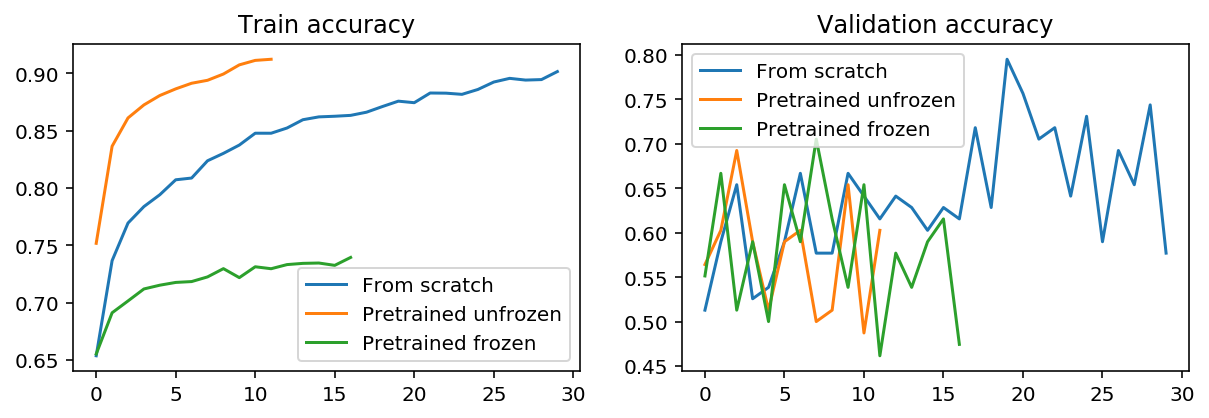

In [5]:
# And now the accuracies

fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].set_title('Train accuracy')
ax[0].plot(from_scratch['acc_train'], label='From scratch')
ax[0].plot(pretrained_open['acc_train'], label='Pretrained unfrozen')
ax[0].plot(pretrained_frozen['acc_train'], label='Pretrained frozen')
ax[0].legend()

ax[1].set_title('Validation accuracy')
ax[1].plot(from_scratch['acc_valid'], label='From scratch')
ax[1].plot(pretrained_open['acc_valid'], label='Pretrained unfrozen')
ax[1].plot(pretrained_frozen['acc_valid'], label='Pretrained frozen')
ax[1].legend()

# So what?
There are a few conclusions to be drawn from here:
- The task is "doable" since >90% accuracy can be achieved on the train set.
- More proof that it's doable is the fact that all configurations (not just the three shown here) achieve > random accuracy.
- The unfrozen pre-trained model performs much better than the frozen pre-trained model, but also better than the one trained from scratch. Keeping in mind the terrible overfitting, this suggests to me that the pre-trained weights are actually beneficial but not ideal, since here we're not working with natural images. So my take is that the pre-trained weights may provide a nice starting point, especially since we currently believe that the patterns in our dataset don't have much diversity. 

It's also interesting to note that the model trained from scratch survived the longest and actually managed to have a slightly downward trend in validation loss. I expect that if (nay, *when!*) we fix the overfitting this will eventually provide the best performance.
